# 👁️ See through filters
We are here guyz, the moment we were waiting for.... okay I got you. I shouldn't talk much 🤫

### ㊙️ The syntax
This is the overall theme
```python
... # mysterious code (which we will learn)
model = Model(input_layer, output_layer)
model.compile(...)
model.fit()
model.predict()
```

That's it. That is what we **already** know. Now, let's have a look at how do we define the convolution layers.

### 〰️ 1D convolution
<img src="../images/conv-syntax.png" height=400 width=500>

We can see that it is pretty straight forward and we can think of it as...

# $$y = \sigma(W * x + b)$$
Where, <br>
- $*:$ is the sign of convolution
- $W:$ is the filter
- $x:$ the image
- $b:$ the bias terms


### ⬛ 2D convolution
<img src="../images/conv2d.png" height=400 width=500>

I've found some amazing resources on the internet that will help you to "visualize " the neural networks and how do they act with convolutions:

- [Images and convolutions](https://www.youtube.com/watch?v=f0t-OCG79-U)
- [3D NNs](https://www.youtube.com/watch?v=3JQ3hYko51Y)
- [Interactive visualization](https://www.cs.ryerson.ca/~aharley/vis/) *(doesn't work for me while I am writing)*

This is the great channel to start visual understanding:
- [Futurology](https://www.youtube.com/watch?v=pj9-rr1wDhM)

# 

# 👨‍💻 Code 

Since we will be going for the *"time series with CNN"*, we will be experimenting with the airline passengers' dataset.

In [56]:
# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 10)

# neural net imports
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# evaluation improts
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.layers import (
    Conv1D,
    Dense,
    GlobalMaxPooling1D,
    Input,
    MaxPooling1D,
)
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# loading the data
passengers = pd.read_csv(
    "../data/airline_passengers.csv", parse_dates=True, index_col=0
)

In [3]:
passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


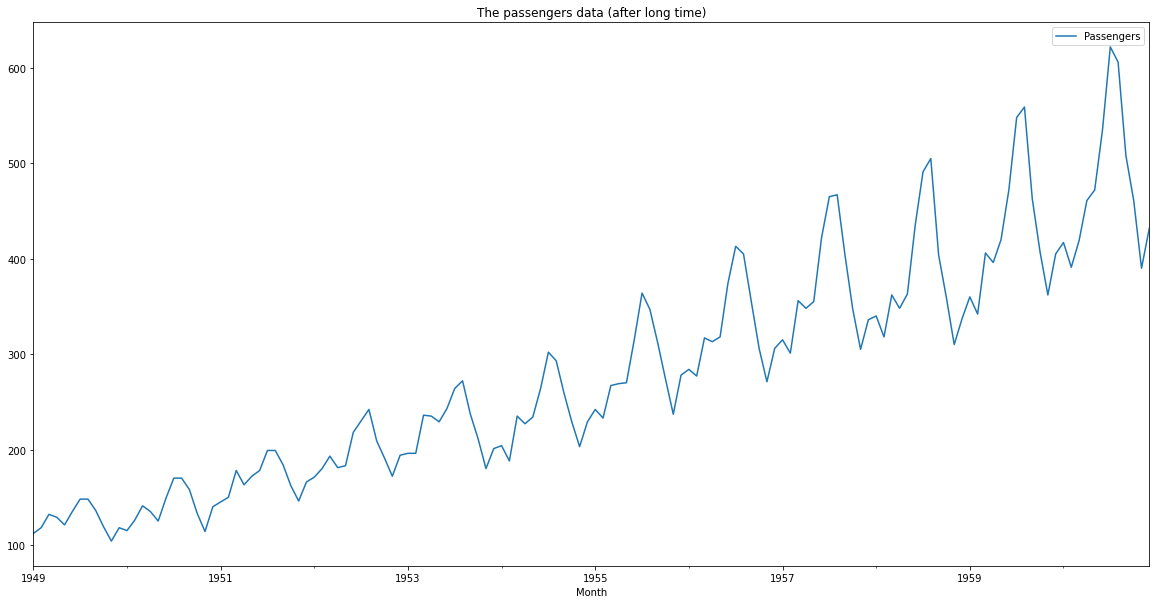

In [4]:
passengers.plot()
plt.title("The passengers data (after long time)");

In [5]:
train_idx = passengers.iloc[:-12].index
test_idx = passengers.iloc[-12:].index

> Since we are *exploring* the technology, I am avoiding the log-conversion and the differentiation so that we can see the **actual** values going in and coming out.

### 👬 Hold on
We are exploring the **time series with CNN** so, again we will be going for:
1. One step forecast
2. Multi step forecast
3. Multi output forecast

### `1.` One Step

In [6]:
passengers_np = passengers.values.flatten()

In [166]:
# data transformation into a supervised learning
T = 10  # taking past 10 data
X = []
y = []

for offset in range(0, len(passengers_np) - T):
    X.append(passengers_np[offset : offset + T])
    y.append(passengers_np[offset + T])

X = np.array(X)
y = np.array(y)

Now, we will make the neural network

In [8]:
# The CNN

input_layer = Input(shape=(T,))
conv_layer = Conv1D(filters=16, kernel_size=3, activation="relu")(input_layer)
pool_layer = MaxPooling1D(pool_size=2)(conv_layer)
conv_layer = Conv1D(filters=32, kernel_size=3, activation="relu")(pool_layer)
global_max = GlobalMaxPooling1D()(conv_layer)
fully_connected = Dense(1)(global_max)
model = Model(input_layer, fully_connected)

ValueError: Input 0 of layer "conv1d" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 10)

#### Oopsie!
Can you see that error?

That was made intentionally. See, **this is not the regular ANN** ans so we need to set the network accordingly. But, what went wrong?

```python
# this went wrong.
input_layer = Input(shape=(T,))
```

The minimum shape that a CNN can accept as an input is `N x T x D` <br>
Now you will say: "***BRO!***" This is then the **3D**, right?

No. <br>
This isn't 3D this is the 2D. 

Let me explain. <br>
<img src="../images/NxTxD.png" height=400 width=500>

Here, <br>
$T:$ is the simple passengers data (1,2,3) <br>
$D:$ is the same data observed from multiple dimensions *(in the passengers examples, there will not be multiple dimensions, so we will keep 1)* <br>
$N:$ is the number of examples **not** making it the 3D data!

**So, how does the 3D data looks like if N x T x D isn't 3D** <br>
Valid question, that would look like: `N x H x W x D`.

Because H x W x D corresponds to the SINGLE instance and that has the 3 dimensions, hence 3D while the `N` represents the number of samples.

> Thus, **the dataset is 4D but the data instance is 3D, and we have to pass the data one by one in the CNN so it has to know about the instance's shape**

___
In our example, our data (passengers) is 1D. And for the ANN point of view it is a perfect as the dataset is of the shape N x T. But when we are *(forcefully)* using CNN, then we should have data of ***at least*** 2D in shape. Otherwise it wouldn't make any sense to use CNN.

Thus, we will ***treat*** our passengers 1D data as 2D: `N x T` → `N x T x D`.

In [61]:
# The CNN (revised)

# Here we are adding the 'D'  ↓
input_layer = Input(shape=(T, 1))
conv_layer = Conv1D(filters=16, kernel_size=3, activation="relu")(input_layer)
pool_layer = MaxPooling1D(pool_size=2)(conv_layer)
conv_layer = Conv1D(filters=32, kernel_size=3, activation="relu")(pool_layer)
global_max = GlobalMaxPooling1D()(conv_layer)
fully_connected = Dense(1)(global_max)
model = Model(input_layer, fully_connected)

Note that CNN doesn't care about the `N`. Because that can be anything! 100, 10000, or ... any number of rows in the dataset. So, we won't be writing for the data `N x T x D`:

```python
# this is wrong for the 2D data ❌
input_layer = Input(shape=(N, T, 1))
```

If we do, then CNN would understand that the data we will be passing is of 3 dimensions. 

### Since,
we have made the network to believe that the data is 2D while it is 1D, we should also make our data 2D *(actually)*.

In [10]:
X[:3]

array([[112, 118, 132, 129, 121, 135, 148, 148, 136, 119],
       [118, 132, 129, 121, 135, 148, 148, 136, 119, 104],
       [132, 129, 121, 135, 148, 148, 136, 119, 104, 118]], dtype=int64)

In [168]:
XX = X.reshape(-1, T, 1)
XX.shape

(134, 10, 1)

In [169]:
XX[:3]

array([[[112],
        [118],
        [132],
        [129],
        [121],
        [135],
        [148],
        [148],
        [136],
        [119]],

       [[118],
        [132],
        [129],
        [121],
        [135],
        [148],
        [148],
        [136],
        [119],
        [104]],

       [[132],
        [129],
        [121],
        [135],
        [148],
        [148],
        [136],
        [119],
        [104],
        [118]]], dtype=int64)

> We are living in the multiverse.

In [62]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 8, 16)             64        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 16)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 33  

Please give **some time** to read the ` Output Shape ` column in the table above. Observe how the shape of the image changes.

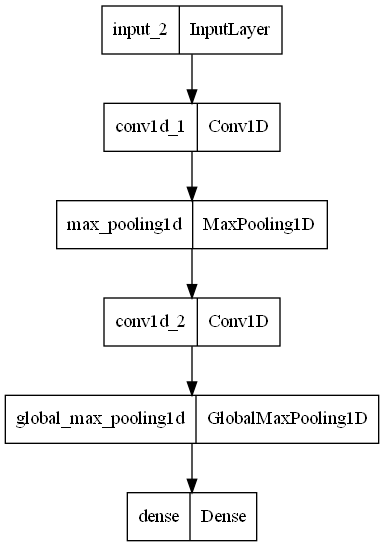

In [14]:
tf.keras.utils.plot_model(model)

### 🛣 Side Track

This is what the CNN will see when we will pass the passengers data.

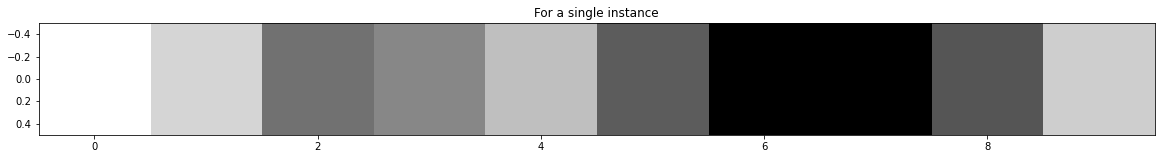

In [15]:
plt.imshow(X[0].reshape(1, -1), cmap="binary")
plt.title("For a single instance");

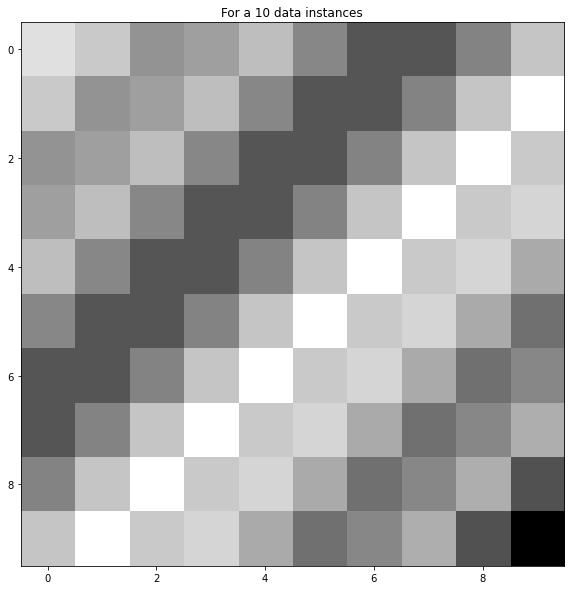

In [16]:
plt.imshow(X[:10], cmap="binary")
plt.title("For a 10 data instances");

Since this is the time-series converted into a supervised data, the training instances will have the repeating elements. Don't worry... it looks good still.

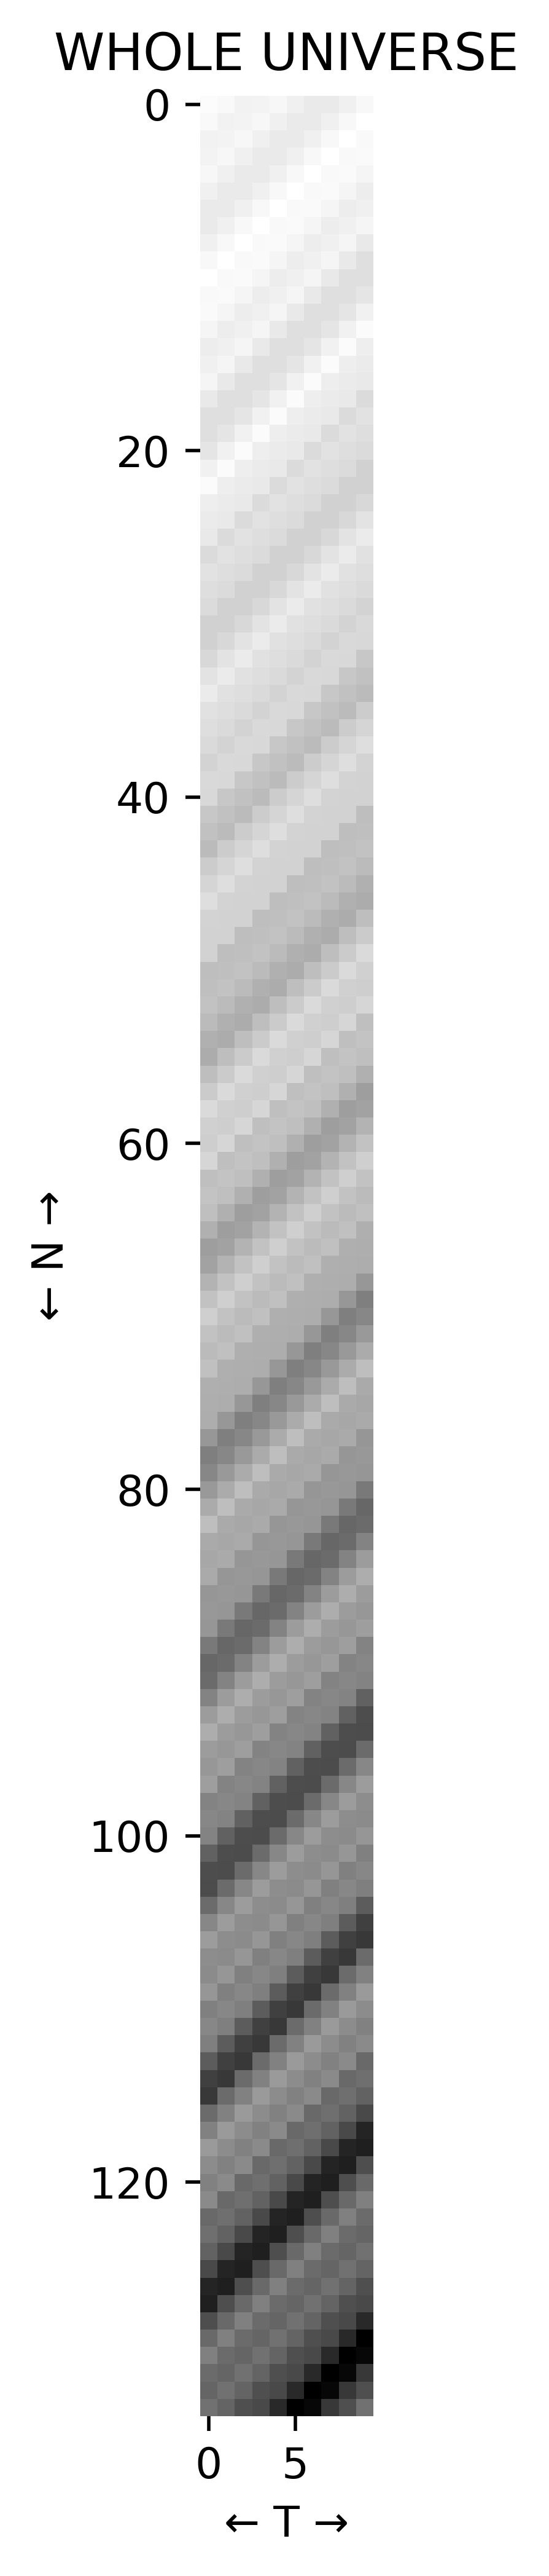

In [17]:
plt.figure(dpi=500)
ax = plt.axes()
ax.imshow(X[:], cmap="binary")
plt.title("WHOLE UNIVERSE")
plt.xlabel("← T →")
plt.ylabel("← N →")

ax.spines.top.set(visible=False)
ax.spines.right.set(visible=False)
ax.spines.left.set(visible=False)
ax.spines.bottom.set(visible=False);

We can see the **repeating pattern** or the seasonality effect in the data through eyes!

#### Back from the track 

In [63]:
# model compilation
model.compile(optimizer="adam", loss="mse", metrics=["mse", "mae"])

In [170]:
Xtr = XX[:-12]
Xte = XX[-12:]
ytr = y[:-12]
yte = y[-12:]

In [171]:
# recall the shape of the training data !
Xtr.shape

(122, 10, 1)

In [58]:
# making a checkpoint
check_point = ModelCheckpoint(
    "./best_model_for_airline.h5", monitor="val_mse", save_best_only=True
)

In [66]:
results = model.fit(
    Xtr,
    ytr,
    epochs=1000,
    validation_data=(Xte, yte),
    verbose=0,
    callbacks=[check_point, TqdmCallback(verbose=0)],
)

0epoch [00:00, ?epoch/s]

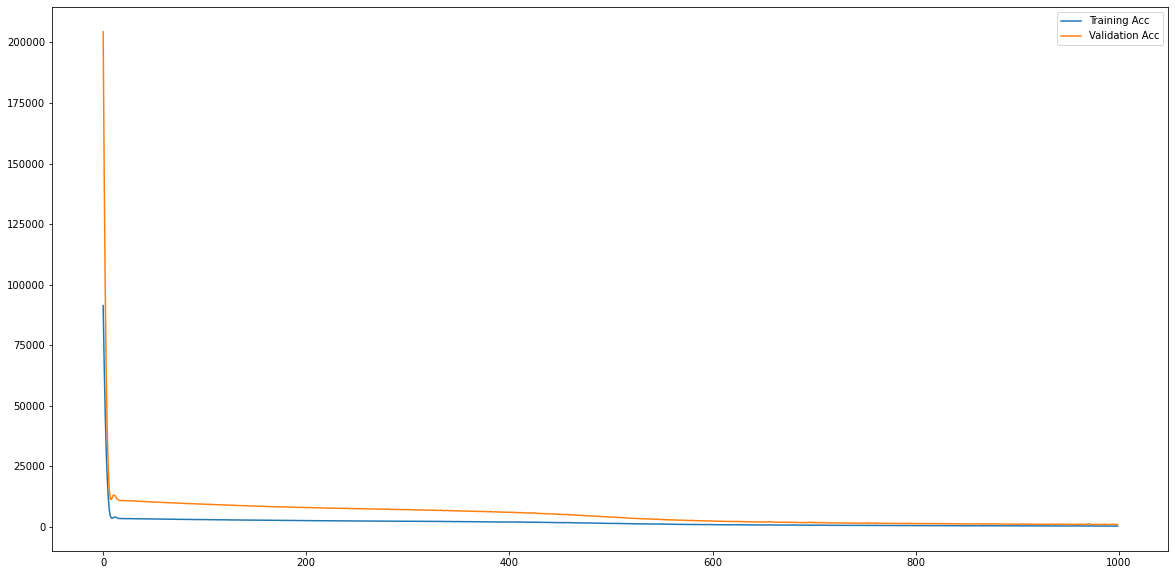

In [67]:
plt.plot(results.history["mse"], label="Training Acc")
plt.plot(results.history["val_mse"], label="Validation Acc")
plt.legend();

In [69]:
# loading the best model
best_model = tf.keras.models.load_model("./best_model_for_airline.h5")

In [75]:
# testing
prediction_train = best_model.predict(Xtr).flatten()
prediction_test = best_model.predict(Xte).flatten()

1/1 [==============================] - 0s 25ms/step


In [78]:
len(prediction_train)

122

In [79]:
len(train_idx)

132

In [87]:
passengers.loc[train_idx[T:], "1Step-PredTrain"] = prediction_train
passengers.loc[test_idx, "1Step-PredTest"] = prediction_test

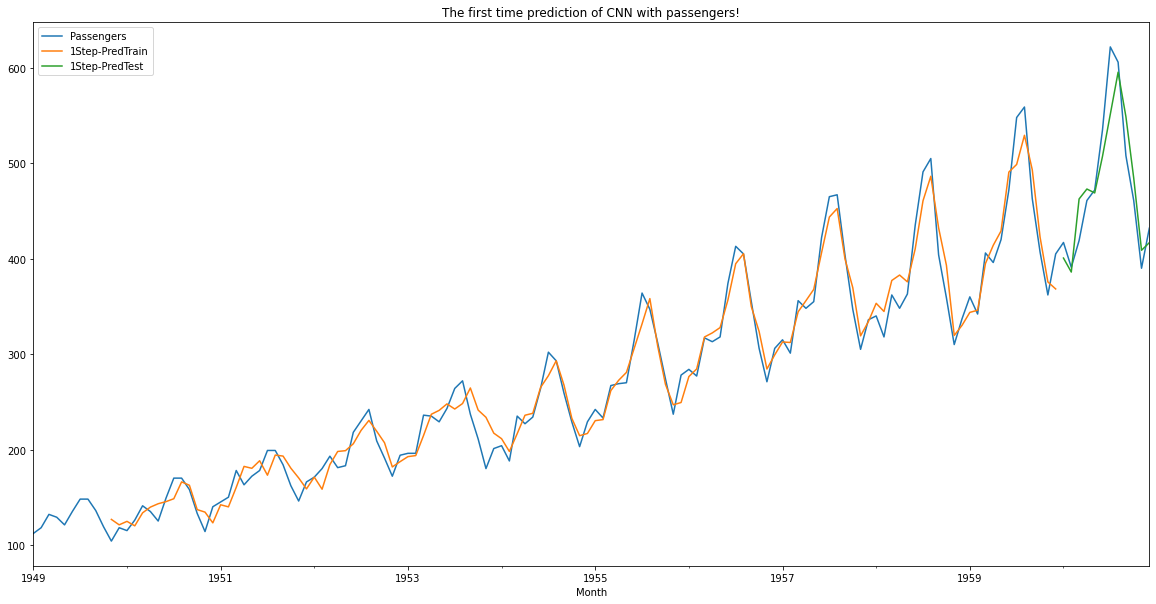

In [89]:
passengers.plot()
plt.title("The first time prediction of CNN with passengers!");

### `2.` Multi Step

In [172]:
last_xte = Xte[0].reshape(1, T, -1)
multi_step_pred = []
for i in range(yte.shape[0]):
    pred = best_model.predict(last_xte).flatten()
    last_xte = np.roll(last_xte, -1)
    last_xte[0, -1, -1] = pred
    multi_step_pred.append(pred)

1/1 [==============================] - 0s 25ms/step


In [173]:
passengers.loc[test_idx, "MultiStep-Pred"] = np.array(multi_step_pred).flatten()

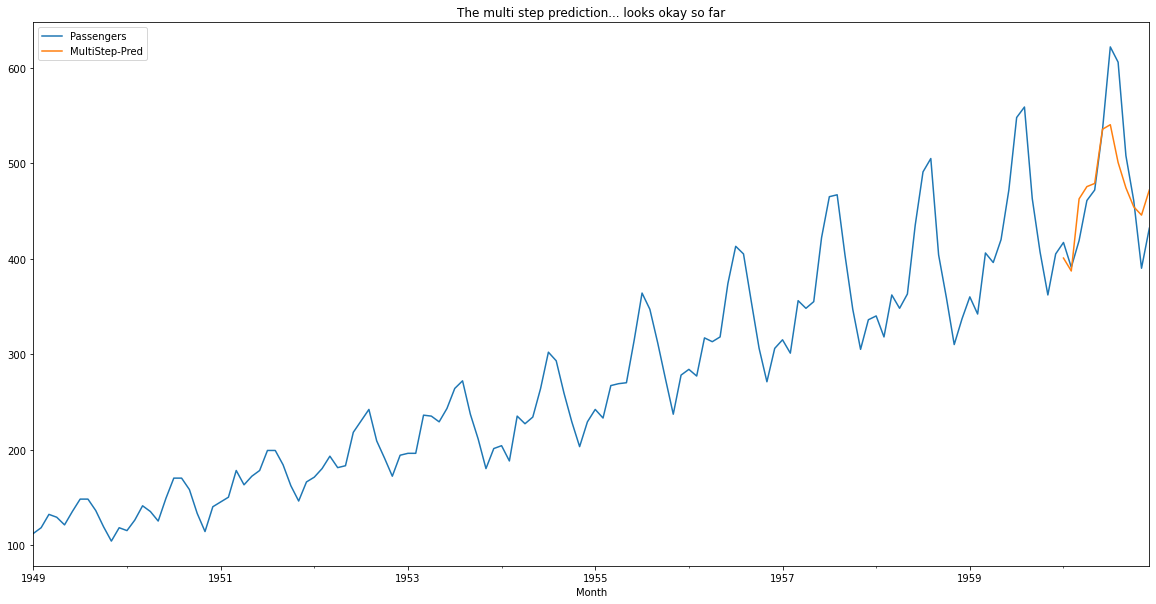

In [176]:
passengers[["Passengers", "MultiStep-Pred"]].plot()
plt.title("The multi step prediction... looks okay so far");

# `3.` Multi output model

In [182]:
# for this we will have to construct another dataset
# the current supervised dataset won't help.

T = 10
h = 12
X, y = [], []
for offset in range(len(passengers_np) - T - h + 1):
    X.append(passengers_np[offset : offset+T])
    y.append(passengers_np[offset+T : offset+T+h])
    
X = np.array(X)
y = np.array(y)

In [201]:
XX_m = X.reshape(-1, T, 1)

In [183]:
XX_m = XX

array([[112, 118, 132, ..., 148, 136, 119],
       [118, 132, 129, ..., 136, 119, 104],
       [132, 129, 121, ..., 119, 104, 118],
       ...,
       [360, 342, 406, ..., 559, 463, 407],
       [342, 406, 396, ..., 463, 407, 362],
       [406, 396, 420, ..., 407, 362, 405]], dtype=int64)

In [29]:
Xtr_m, ytr_m = X[:-1], y[:-1]
Xte_m, yte_m = X[[-1]], y[[-1]]